# **SLDS DoubleScroll 3D 6states**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import time as time
import random 
import reservoirpy.datasets as rsvp_d

from scipy.special import logsumexp
from scipy.stats import multivariate_normal, invwishart, matrix_normal

## Data generation

In [2]:
def Plot3D(xs, ys, zs, title, start, pt_number, lw):
    ax = plt.figure().add_subplot(projection='3d')
    ax.plot(xs[start:start+pt_number], ys[start:start+pt_number], zs[start:start+pt_number], lw=lw)
    ax.set_xlabel("X Axis")
    ax.set_ylabel("Y Axis")
    ax.set_zlabel("Z Axis")
    ax.set_title(title)
    plt.show()
    


def Plot2D(xs, ys, zs, titl1, titl2, titl3, start, pt_number, lw):
    fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize = (15, 5))

    ax1.plot(xs[start:start+pt_number], ys[start:start+pt_number], lw=lw)
    ax1.set_title(titl1)
    ax1.set_xlabel("X Axis")
    ax1.set_ylabel("Y Axis")

    ax2.plot(xs[start:start+pt_number], zs[start:start+pt_number], lw=lw)
    ax2.set_title(titl2)
    ax2.set_xlabel("X Axis")
    ax2.set_ylabel("Z Axis")

    ax3.plot(ys[start:start+pt_number], zs[start:start+pt_number], lw=lw)
    ax3.set_title(titl3)
    ax3.set_xlabel("Y Axis")
    ax3.set_ylabel("Z Axis")

    plt.show()

In [3]:
t1 = time.time() #times the computation
arr = rsvp_d.doublescroll(2500, r1=1.2, r2=3.44, r4=0.193, ir=4.5e-05, beta=11.6, x0=[0.37926545, 0.058339, - 0.08167691], h=0.25)
xs = arr[:,0]
ys = arr[:,1]
zs = arr[:,2]
t2 = time.time()
print ('computation takes ',t2-t1,' seconds.')

/usr/local/lib/python3.10/dist-packages/reservoirpy/datasets/_chaos.py:430: RuntimeWarning: overflow encountered in sinh
  factor = (dV / r2) + ir * np.sinh(beta * dV)
/usr/local/lib/python3.10/dist-packages/reservoirpy/datasets/_chaos.py:431: RuntimeWarning: invalid value encountered in double_scalars
  dV1 = (V1 / r1) - factor
/usr/local/lib/python3.10/dist-packages/scipy/integrate/_ivp/rk.py:109: RuntimeWarning: invalid value encountered in true_divide
  return norm(self._estimate_error(K, h) / scale)


computation takes  0.44043612480163574  seconds.


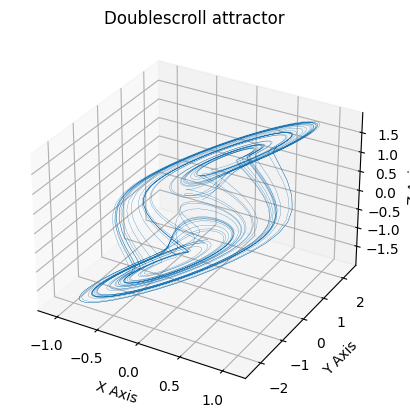

In [4]:
Plot3D(ys, zs, xs, "Doublescroll attractor", start=0, pt_number=2500, lw=0.2)

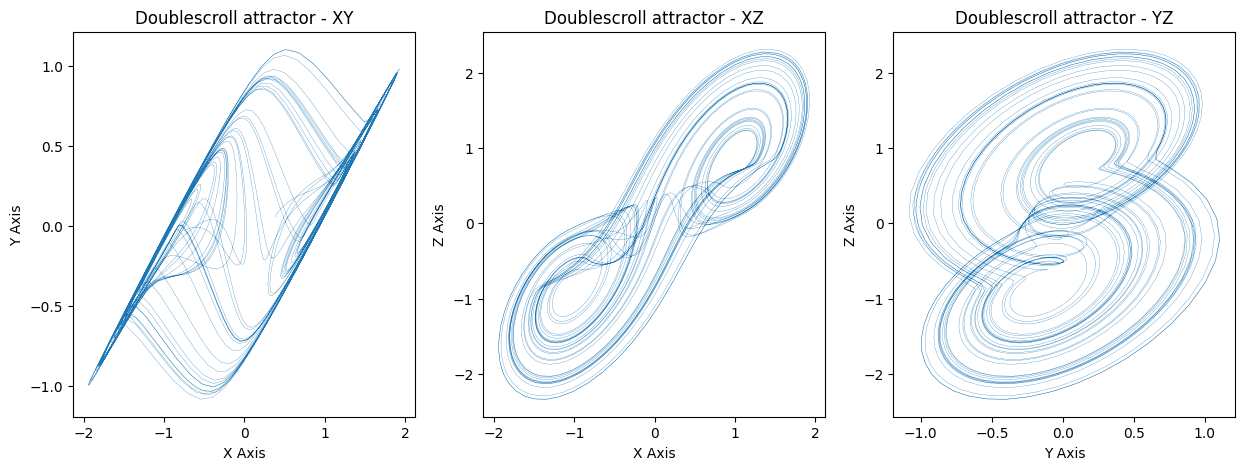

In [5]:
Plot2D(xs, ys, zs, "Doublescroll attractor - XY", "Doublescroll attractor - XZ", "Doublescroll attractor - YZ", start=0, pt_number=2500, lw=0.2)

In [6]:
y = arr[0:1000,0:3].copy()
y[:, 0] = y[:, 0]/2.5
y[:, 1] = y[:, 1]/1.1
y[:, 2] = y[:, 2]/2.5
y.shape

(1000, 3)

(-1.0, 1.0)

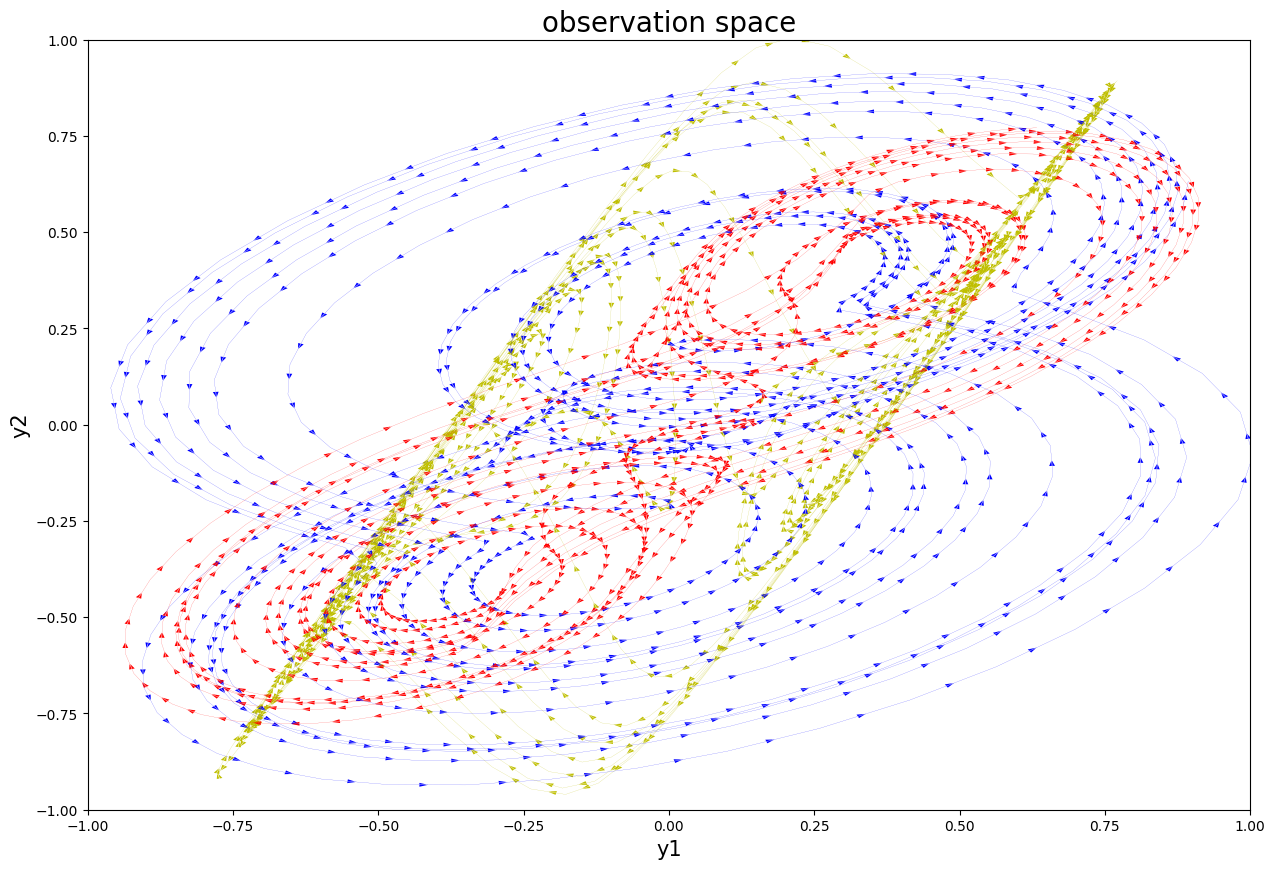

In [7]:
plt.rcParams["figure.figsize"] = (15,10)

plt.plot(y[:, 0], y[:, 1], lw = 0.1, color = "y")
plt.plot(y[:, 1], y[:, 2], lw = 0.1, color = "b")
plt.plot(y[:, 2], y[:, 0], lw = 0.1, color = "r")

# code to add the arrows in the middle of the lines (fix head_width if needed)
for t in range(y.shape[0]-1):
    arr_mean_y1 = np.mean([y[t, 0], y[t+1, 0]])
    arr_mean_y2 = np.mean([y[t, 1], y[t+1, 1]])
    dy1 = y[t+1, 0] - y[t, 0]
    dy2 = y[t+1, 1] - y[t, 1]
    plt.arrow(arr_mean_y1, arr_mean_y2, 0.01*dy1, 0.01*dy2, shape='full', lw=0, length_includes_head=True, head_width=0.01, color = "y")
    
for t in range(y.shape[0]-1):
    arr_mean_y1 = np.mean([y[t, 1], y[t+1, 1]])
    arr_mean_y2 = np.mean([y[t, 2], y[t+1, 2]])
    dy1 = y[t+1, 1] - y[t, 1]
    dy2 = y[t+1, 2] - y[t, 2]
    plt.arrow(arr_mean_y1, arr_mean_y2, 0.01*dy1, 0.01*dy2, shape='full', lw=0, length_includes_head=True, head_width=0.01, color = "b")
    
for t in range(y.shape[0]-1):
    arr_mean_y1 = np.mean([y[t, 2], y[t+1, 2]])
    arr_mean_y2 = np.mean([y[t, 0], y[t+1, 0]])
    dy1 = y[t+1, 2] - y[t, 2]
    dy2 = y[t+1, 0] - y[t, 0]
    plt.arrow(arr_mean_y1, arr_mean_y2, 0.01*dy1, 0.01*dy2, shape='full', lw=0, length_includes_head=True, head_width=0.01, color = "r")
    
plt.xlabel("y1", fontsize = 15)
plt.ylabel("y2", fontsize = 15)
plt.title("observation space", fontsize = 20)
plt.xlim(-1,1)
plt.ylim(-1,1)

## Inference

In [8]:
# to generate a random semipositive matrix
def generate_random_semipositive_matrix(dim, scale):

    tm = np.random.randn(dim, dim)
    test_matrix = scale*np.dot(tm, tm.T)
    
    return test_matrix

In [9]:
T = y.shape[0] # number of time steps
N = 3 # observation dim
K = 6 # latent dim

L = 40 # how many Gibbs iteration to do

### PRIORS
# IW(Q_k; S, nu)
# MN(A_hat_k; C, Q_k, V)

S = np.array([1/120, 1/80, 1/100])*np.eye(N, N) # 1 meter in each direction
nu = N
C = 0.1*np.random.randn(N, N+1)
C[:, 0] = np.zeros(N)
C[:, 1:] = np.eye(N, N)
#V = generate_random_semipositive_matrix(N+1, 1) # it should be a semipositive matrix, given what i found
V = 1*np.eye(N+1, N+1)

### INFERRED VARIABLES
# inferred samples of z
z_inf = np.zeros((L,T)).astype('int')
z_inf[0] = np.random.randint(K, size = T).astype('int')

# inferred samples of M
M_inf = np.zeros((L,K,K))
M_inf[0] = np.stack([np.random.dirichlet(tuple([1]*K)) for i in range(K)])
#M_inf[0] = np.copy(M)

A_hat_inf = np.zeros((L, K, N, N+1))
A_hat_inf[0][:, :, 0] = 1*np.random.randn(K, N)
A_hat_inf[0][:, :, 1:] = 1*np.random.randn(K, N, N)
#A_hat_inf[0] = np.copy(A_hat) + 0.05*np.random.randn(K, N, N+1)

# inferred samples of Q_k
Q_inf = np.zeros((L,K,N,N))
Q_inf[0] = np.stack([np.array([1/120, 1/80, 1/100])*np.eye(N, N) for k in range(K)])# + np.copy(Q)# + 0.06*np.random.randn(K, N, N)

# inferred alpha parameters for the conditional dirichlet (to sample M)
alpha_inf = np.ones((L,K,K))

print(A_hat_inf[0])

[[[ 1.04460966 -0.48279501  0.7399543  -0.02772533]
  [-0.32388587 -0.59485356  0.58840898  0.6265071 ]
  [-0.19310216 -0.7534714  -0.79142491  0.44166979]]

 [[-0.63379742  0.17807843 -1.1549409   0.50520971]
  [-0.8742061   1.3536119   0.25860012 -0.33863881]
  [-1.06792215  1.28063059 -0.8022188   0.03684043]]

 [[ 1.05624626  1.50681224  0.23797467 -0.40970799]
  [ 0.22434053 -0.93357258  0.77384332  1.73387871]
  [-1.02470109  0.56370781 -0.31685023 -1.93523001]]

 [[-0.54661554 -1.35389279 -0.27872806  1.38785522]
  [-3.09157886  0.74320587  1.84972645  0.0473646 ]
  [ 2.31003303 -0.99908914  0.55665076  0.60302849]]

 [[-0.24580914  0.14135327  2.33123655 -0.61838596]
  [-1.00796192  0.29739045  1.08020413  0.70554004]
  [-0.38376283  1.16554986  0.6295545  -1.19743953]]

 [[-0.36677122 -2.01330531  0.29819529  0.47366836]
  [ 0.19191704  0.70294529  0.820267    0.25526842]
  [-0.90560543  0.95430676  1.62410031 -1.46690063]]]


In [10]:
b_inf = A_hat_inf[0][:,:,0]
A_inf = A_hat_inf[0][:,:,1:]

In [11]:
### function to try to implement forward-backward algo

def message_passing(M_inf_l, A_hat_inf_l, Q_inf_l):
    m = [np.array([1]*K)]
    log_m = [np.array([0]*K)]

    for t in reversed(range(1,T)): # T-1, T-2, ...
        y_hat = np.concatenate([np.array([1]), y[t-1]])
        somm = np.zeros((K, K))
        m_t = np.zeros(K) # log of message at time t
        for k in range(K):
            for j in range(K):
                rv = multivariate_normal(np.zeros(N), Q_inf_l[j])
                x = y[t] - np.dot(A_hat_inf_l[j], y_hat)
                somm[k,j] = np.log(M_inf_l[k,j]) + rv.logpdf(x) + log_m[T-1-t][j]
        
        for k in range(K):
            m_t[k] = logsumexp(somm[k])
        
        log_m.append(m_t) # list of log messages

    log_p_z = np.zeros((T, K))
    z_inf_l = np.zeros(T).astype('int')

    for k in range(K):
        log_p_z[0, k] = log_m[T-1][k]
    log_p_z[0] = log_p_z[0] - logsumexp(log_p_z[0])
    z_inf_l[0] = np.random.choice(K, p = np.exp(log_p_z[0]))

    for t in range(1,T):
        y_hat = np.concatenate([np.array([1]), y[t-1]])
        for k in range(K):
            rv = multivariate_normal(np.zeros(N), Q_inf_l[k])
            x = y[t] - np.dot(A_hat_inf_l[k], y_hat)
            log_p_z[t, k] = np.log(M_inf_l[z_inf_l[t-1],k]) + rv.logpdf(x) + log_m[T-1-t][k]
        log_p_z[t] = log_p_z[t] - logsumexp(log_p_z[t])
        z_inf_l[t] = np.random.choice(K, p = np.exp(log_p_z[t]))

    return z_inf_l

In [12]:
### Gibbs sampling loop, update in sequence: z, M, A_hat, Q

for l in range(L-1):
    
    print("\n SAMPLE:", l)
    
    ### UPDATE z_t

    z_inf[l+1] = message_passing(M_inf[l], A_hat_inf[l], Q_inf[l])
    #z_inf[l+1] = myconditionals(M_inf[l], A_hat_inf[l], Q_inf[l], z_inf[l])

    ## UPDATE M
    
    # computing how many times there is a transition from state k to state j
    chi = np.zeros((K, K))
    
    for k in range(K):
        for j in range(K):
            somm = 0
            for t in range(T-1):
                if z_inf[l+1, t] == k and z_inf[l+1, t+1] == j:
                    somm += 1
            chi[k, j] = somm
    
    # updating conditional dirichlet parameters alpha initially set to [1,1,...,1] matrix
    alpha_inf[l+1] += chi
    
    # sampling rows of M from conditional distribution P(M|alpha)
    for k in range(K):
        M_inf[l+1, k] = np.random.dirichlet(tuple(alpha_inf[l+1, k]))
        
    #print(" \n alpha:")
    #print(alpha_inf[l+1])
    
    ### UPDATE MODEL PARAMETERS (see overleaf)
    
    # create data matrix grouped by state, all y_t where z_t = k
    Y = [[] for k in range(K)]

    # create data matrix grouped by state, all y_{t-1} where z_t = k
    Y_bar = [[] for k in range(K)]

    # number of observations belonging to a given state k
    N_k = np.zeros(K)
    
    #print("\n N_k:")
    
    for k in range(K):
        for t in range(1, T):
            if z_inf[l+1, t] == k:
                Y[k].append(y[t])
                Y_bar[k].append(np.concatenate([np.array([1]), y[t-1]]))
    
        N_k[k] = len(Y[k])
        #print(N_k[k])
        if N_k[k] != 0:
            Y[k] = np.stack(Y[k]).T
            Y_bar[k] = np.stack(Y_bar[k]).T
        
    # sufficient statistics for MNIW (see overleaf)
    
    S_ybar_ybar = np.zeros((K, N+1, N+1))
    S_y_ybar = np.zeros((K, N, N+1))
    S_y_y = np.zeros((K, N, N))
    S_y_given_ybar = np.zeros((K, N, N))
    
    for k in range(K):
        if N_k[k] != 0:
            #print(Y_bar[k].shape)
            S_ybar_ybar[k] = np.dot(Y_bar[k], Y_bar[k].T) + V
            S_y_ybar[k] = np.dot(Y[k], Y_bar[k].T) + np.dot(C, V)
            S_y_y[k] = np.dot(Y[k], Y[k].T) + C @ V @ C.T
            S_y_given_ybar[k] = S_y_y[k] - S_y_ybar[k] @ np.linalg.inv(S_ybar_ybar[k]) @ S_y_ybar[k].T
    
    # sampling from IW and MN with updated hyperparameters
    
    for k in range(K):
        if N_k[k] != 0:
            rv_iw = invwishart(nu + N_k[k], S + S_y_given_ybar[k])
            Q_inf[l+1, k] = rv_iw.rvs(size = 1)
            
            # INVERSE OF Q OR NOT?
            rv_mn = matrix_normal(S_y_ybar[k] @ np.linalg.inv(S_ybar_ybar[k]), Q_inf[l+1, k], np.linalg.inv(S_ybar_ybar[k]))
            A_hat_inf[l+1, k] = rv_mn.rvs(size = 1)
        else:
            # keep the same o sample a fresh new? (from the priors maybe)
            rv_iw = invwishart(nu, S)
            Q_inf[l+1, k] = rv_iw.rvs(size = 1)
            rv_mn = matrix_normal(C, Q_inf[l+1, k], V)
            A_hat_inf[l+1, k] = rv_mn.rvs(size = 1)

            #Q_inf[l+1, k] = Q_inf[l, k] 
            #A_hat_inf[l+1, k] = 1*np.random.randn(N, N+1)


 SAMPLE: 0

 SAMPLE: 1

 SAMPLE: 2

 SAMPLE: 3

 SAMPLE: 4

 SAMPLE: 5

 SAMPLE: 6

 SAMPLE: 7

 SAMPLE: 8

 SAMPLE: 9

 SAMPLE: 10

 SAMPLE: 11

 SAMPLE: 12

 SAMPLE: 13

 SAMPLE: 14

 SAMPLE: 15

 SAMPLE: 16

 SAMPLE: 17

 SAMPLE: 18

 SAMPLE: 19

 SAMPLE: 20

 SAMPLE: 21

 SAMPLE: 22

 SAMPLE: 23

 SAMPLE: 24

 SAMPLE: 25

 SAMPLE: 26

 SAMPLE: 27

 SAMPLE: 28

 SAMPLE: 29

 SAMPLE: 30

 SAMPLE: 31

 SAMPLE: 32

 SAMPLE: 33

 SAMPLE: 34

 SAMPLE: 35

 SAMPLE: 36

 SAMPLE: 37

 SAMPLE: 38


In [13]:
print(z_inf[0])
print(z_inf[1])
print(z_inf[-1])
print(np.mean(z_inf, axis = 0)) 
unique, counts = np.unique(z_inf[10:], return_counts=True)
print(dict(zip(unique, counts)))

[5 4 0 3 4 1 1 5 5 2 5 4 2 4 2 2 2 5 4 0 0 0 3 2 5 0 2 0 3 5 3 3 4 0 4 3 3
 2 2 0 5 3 5 3 1 2 0 2 2 1 4 4 1 0 3 3 2 0 4 2 5 1 3 0 3 1 1 2 1 5 4 1 3 2
 5 0 5 3 0 4 4 3 5 3 1 1 4 0 4 0 3 0 3 4 3 1 5 5 2 3 5 1 5 5 1 0 0 3 2 2 5
 0 0 4 2 0 1 1 0 2 1 1 1 0 4 2 1 4 2 1 2 1 5 0 3 5 0 1 3 0 4 2 0 0 3 2 0 5
 3 5 5 2 0 0 3 0 4 5 1 3 1 3 2 4 4 4 2 0 1 2 1 5 4 4 2 4 1 1 1 3 2 5 3 4 3
 2 5 0 1 2 3 5 3 3 5 4 5 3 3 4 4 0 1 1 2 1 4 2 5 4 0 1 3 4 4 0 0 0 5 1 4 5
 3 0 4 1 3 3 0 0 1 3 4 1 1 4 3 4 5 5 2 5 4 3 2 4 2 1 5 3 4 5 2 4 0 2 2 0 5
 5 0 2 0 4 5 2 2 4 1 1 3 0 4 2 0 1 2 3 0 2 0 5 0 4 1 3 1 0 5 0 2 4 5 0 4 4
 2 0 5 5 0 4 5 4 5 4 1 2 4 3 1 1 2 0 1 3 0 3 2 2 4 0 5 3 0 1 4 4 0 3 0 2 5
 3 3 0 2 3 4 3 1 1 0 4 5 3 2 0 3 4 5 0 0 2 3 2 5 4 1 1 0 0 0 4 3 2 0 5 3 5
 2 0 1 5 0 4 2 2 4 5 4 4 1 2 2 5 3 5 2 3 5 1 3 2 2 2 1 0 0 1 3 4 5 0 0 1 2
 0 4 3 2 3 3 3 3 0 5 3 5 3 0 3 2 0 2 3 3 5 2 4 2 5 0 1 1 4 0 5 2 3 4 4 0 2
 4 1 0 4 2 4 3 5 0 1 1 2 3 3 5 1 3 0 4 5 5 3 5 3 3 5 0 5 2 1 0 2 4 2 2 5 1
 4 5 4 3 1 5 5 5 3 1 0 1 

In [14]:
print(np.mean(M_inf, axis = 0))
eigw_inf, eigv_inf = np.linalg.eig(np.mean(M_inf, axis = 0).T)
print(eigv_inf.real[:, 0]/np.sum(eigv_inf.real[:, 0]))

[[0.94031234 0.00652921 0.00258422 0.00510248 0.03281876 0.012653  ]
 [0.18118323 0.18431906 0.17365897 0.14531147 0.15210643 0.16342084]
 [0.20025244 0.15184475 0.23539543 0.11121788 0.15674479 0.14454472]
 [0.20499706 0.18201622 0.15122154 0.16599021 0.16509753 0.13067744]
 [0.04904759 0.01346442 0.00909474 0.00651278 0.86327183 0.05860865]
 [0.00819067 0.00220928 0.00782614 0.01047429 0.03407805 0.93722157]]
[0.36292409 0.01290675 0.01316144 0.01267036 0.22492694 0.37341042]


In [15]:
print(np.mean(A_hat_inf, axis = 0))

[[[ 0.04765639  0.98973725  0.05393178 -0.11557907]
  [ 0.04483314  0.03124418  1.04690871 -0.22530327]
  [-0.01177832  0.0136329   0.07224687  0.92689926]]

 [[-0.06243591  1.12423853 -0.07673581  0.14695665]
  [ 0.14587526 -0.20798584  1.11391922 -0.42145623]
  [-0.14143184 -0.01764002 -0.15825722  1.1319978 ]]

 [[-0.33719981  1.36195427  0.49476967  0.00325624]
  [ 0.10649097 -0.29777761  0.6534215   0.22054492]
  [ 0.3879727  -0.64898549 -0.50700636  1.39920859]]

 [[ 0.01180255  0.9366583   0.02321253  0.12302658]
  [-0.34007931  0.0642881   1.27246134 -0.23774282]
  [ 0.39362068  0.0043187  -0.06765938  0.85640703]]

 [[-0.00617581  1.07131005  0.1027965  -0.03090464]
  [-0.0299412   0.11989864  0.92165094 -0.28537207]
  [-0.00984622  0.03493004  0.11373948  0.89227123]]

 [[-0.03139634  0.94710021  0.04504009 -0.10174078]
  [-0.05345447  0.04905169  1.05803047 -0.2345977 ]
  [-0.01481742  0.05693986  0.13207259  0.88006701]]]


In [16]:
Q_inf_av = np.mean(Q_inf, axis = 0)
for k in range(K):
    print(Q_inf_av[k])
    eigw_q, _ = np.linalg.eig(Q_inf_av[k])
    print(eigw_q)

[[2.81392267e-04 8.29845594e-05 2.75699348e-05]
 [8.29845594e-05 5.62096822e-04 5.53914411e-05]
 [2.75699348e-05 5.53914411e-05 3.10324694e-04]]
[0.00059764 0.00025541 0.00030076]
[[ 0.98057391 -0.87954636  0.31754418]
 [-0.87954636  1.61938508 -0.67146033]
 [ 0.31754418 -0.67146033  0.90349516]]
[2.56058434 0.31374376 0.62912604]
[[ 1.75714608 -0.62018991 -1.42087742]
 [-0.62018991  2.32943366  3.3684121 ]
 [-1.42087742  3.3684121   6.66778088]]
[8.8417978  1.43910919 0.47345364]
[[ 0.73852141 -0.77055074 -0.10108043]
 [-0.77055074  2.38963164 -0.66239537]
 [-0.10108043 -0.66239537  1.13672807]]
[2.88988815 0.27724397 1.09774899]
[[ 3.72620427e-04 -1.17886477e-05  2.94743939e-05]
 [-1.17886477e-05  1.48384426e-03  7.68810936e-05]
 [ 2.94743939e-05  7.68810936e-05  3.68998146e-04]]
[0.0003376  0.00039866 0.00148921]
[[2.82384161e-04 8.08758986e-05 2.84888591e-05]
 [8.08758986e-05 5.64378396e-04 5.85916175e-05]
 [2.84888591e-05 5.85916175e-05 3.11686076e-04]]
[0.00060013 0.00025716 0.00

In [17]:
#b_inf_av = np.mean(A_hat_inf[L//2:], axis = 0)[:,:,0]
#A_inf_av = np.mean(A_hat_inf[L//2:], axis = 0)[:,:,1:]
b_inf_av = A_hat_inf[-1][:,:,0]
A_inf_av = A_hat_inf[-1][:,:,1:]

In [18]:
# Define the grid of x, y, z points
y = arr[:1000,0:3].copy()
y[:, 0] = y[:, 0]/11 - 0.1
y[:, 1] = y[:, 1]/10 + 0.1
y[:, 2] = y[:, 2]/11 - 1

z = z_inf[-1]
A = A_inf_av
b = b_inf_av
x_star = np.stack([np.dot(np.linalg.inv(np.eye(N, N) - A[k]), b[k]) for k in range(K)])
U = np.zeros((y.shape[0]))
V = np.zeros((y.shape[0]))
W = np.zeros((y.shape[0]))

# Define the vector field components
for l in range(y.shape[0]):
    k = z[l]
    U[l] = np.dot(A[k], y[l, :].reshape(-1, 3, 1))[0] + b[k, 0] - y[l, 0]
    V[l] = np.dot(A[k], y[l, :].reshape(-1, 3, 1))[1] + b[k, 1] - y[l, 1]
    W[l] = np.dot(A[k], y[l, :].reshape(-1, 3, 1))[2] + b[k, 2] - y[l, 2]

conversion = {0: "b",
              1: "r", 
              2: "y", 
              3: "g", 
              4: "m", 
              5: "c", 
              6: "k", 
              7: "0.2",
              8: "0.5",
              9: "0.8"}

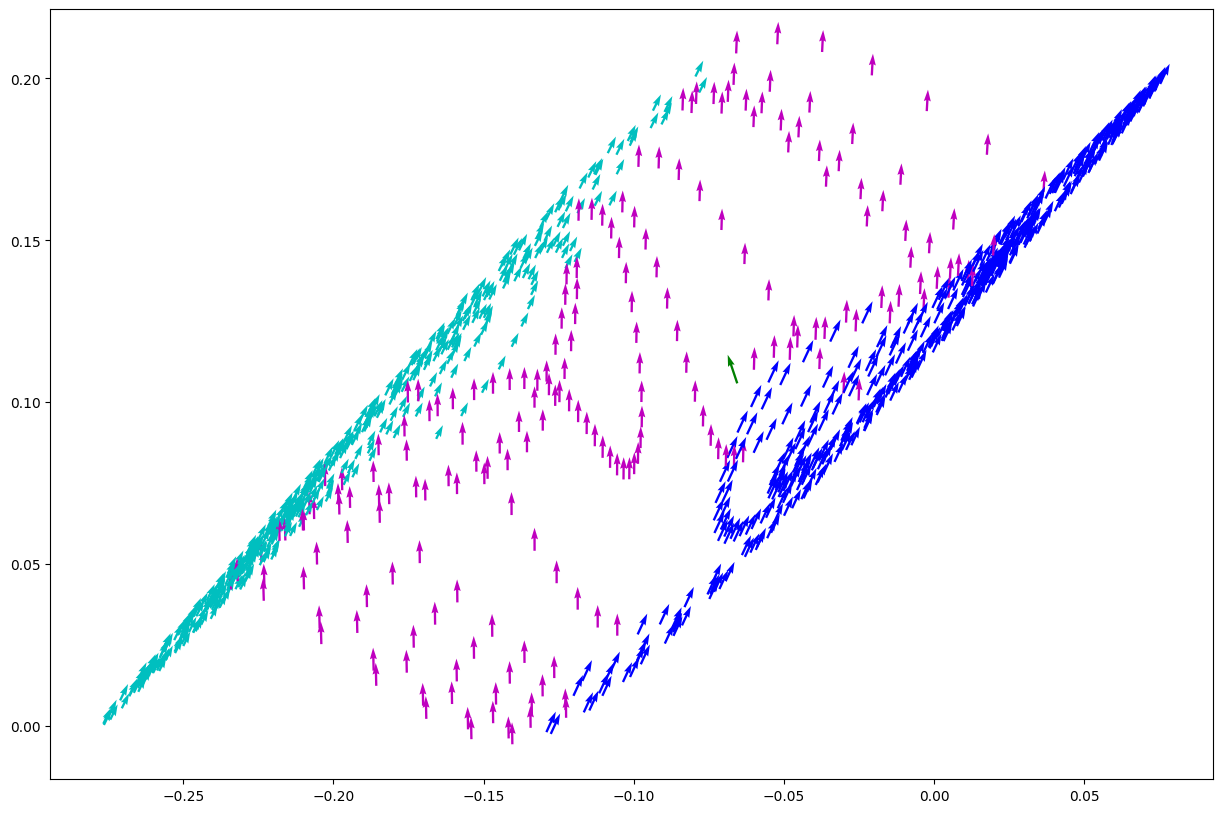

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111)#, projection='3d')

# Plot the 3D vector field
ax.quiver(y[:, 0], y[:, 1], U, V, color = [conversion[i] for i in z], width = 2*1e-3)#, length=0.1, normalize=True, lw = 0.5)
plt.show()

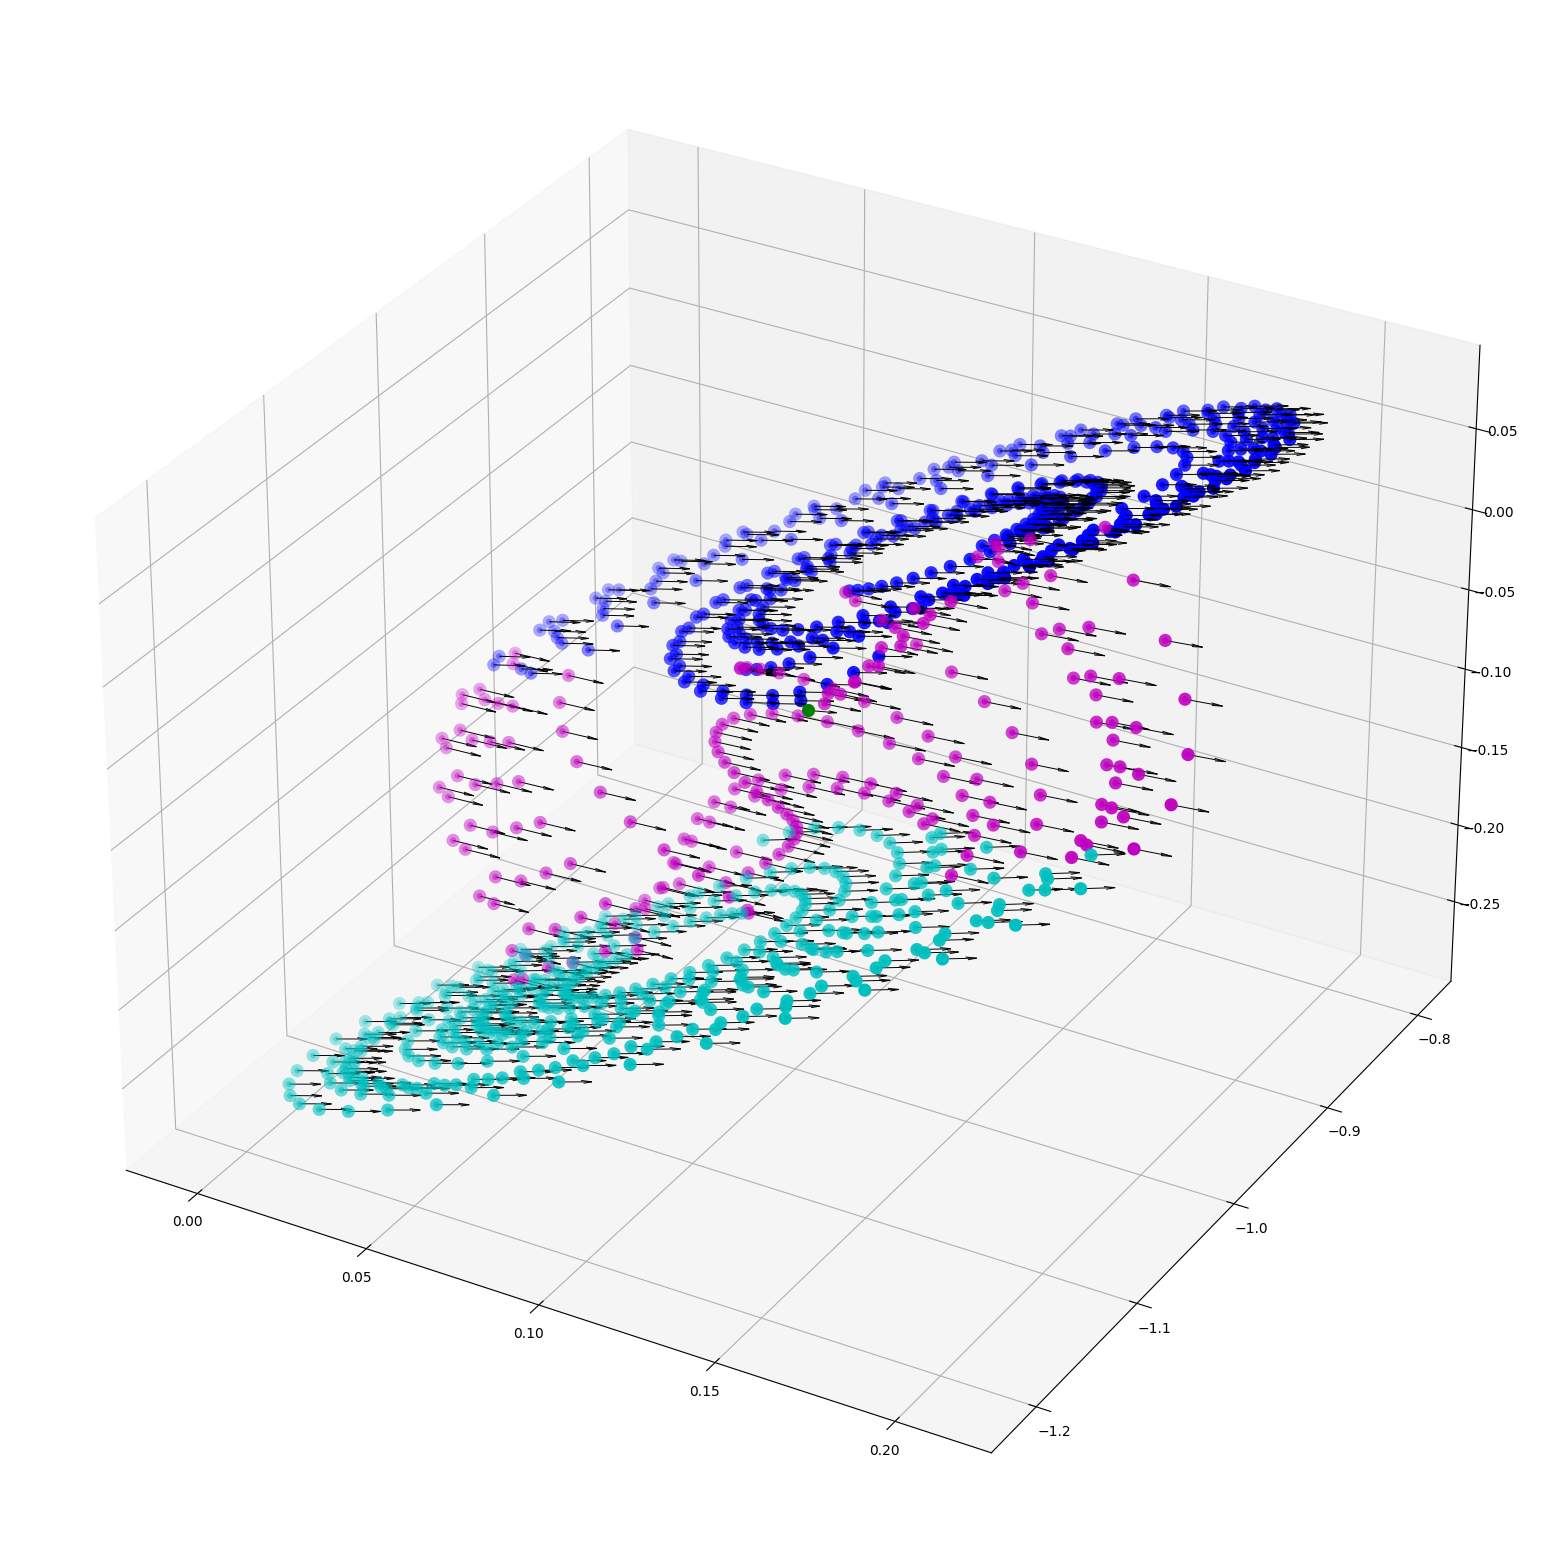

In [20]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D vector field
ax.quiver(y[:, 1], y[:, 2], y[:, 0], V, W, U, length= 1e-2, normalize=True, lw = 0.7, color = "k")
for i in range(K):
    ax.scatter(y[:, 1][z == i], y[:, 2][z == i], y[:, 0][z == i], color = conversion[i], lw = 5)
    
plt.show()